## Code Module 3
Content:
1. Ground Data Cleaning for Spatial Temporal Matching
2. Spatial Temporal Matching between Ground Data and TROPOMI data
3. Correlation Assessment between Ground Data and TROPOMI data
4. Estimating Ground NO2 Concentration Based on TROPOMI data

In [101]:
import rioxarray
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

import scipy.stats as stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error


## Load TROPOMI data
The TROPOMI NO2 data were retrieved at daily interval and approximately 1km spatial resolution. We crop and resampled the data to 5 km (computational load consideration) for state of California on Google Earth Engine. The data specification are:

Name TROPOMI offline total troposphere NO2

unit: mol/m^2

spatial resolution: 5km

temporal resolution: daily



In [102]:
tif = './Data_NO2/S5P_NO2_5km.tif'
data_tif = rioxarray.open_rasterio(tif,masked=False)
NO2_tif = data_tif.values


## 1. Ground Data Cleaning for Spatial Temporal Matching

We found there are omittion in in-situ daily measurements. Inorder to proceed spatial-temporal matching between site data and raster data, the temporal omission in in-situ measurements needs to be filled.

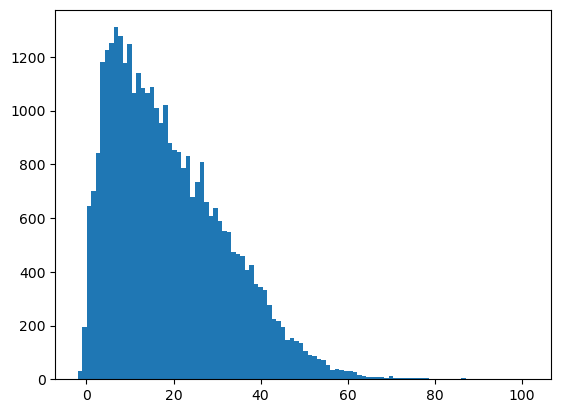

['Date', 'Source', 'Site ID', 'POC', 'Daily Max 1-hour NO2 Concentration', 'Units', 'Daily AQI Value', 'Local Site Name', 'Daily Obs Count', 'Percent Complete', 'AQS Parameter Code', 'AQS Parameter Description', 'Method Code', 'CBSA Code', 'CBSA Name', 'State FIPS Code', 'State', 'County FIPS Code', 'County', 'Site Latitude', 'Site Longitude']
Any site has missing observations? True


In [103]:
site_data_ks = pd.read_csv('./Data_NO2/ca_no2_2020.csv')

# some preliminary assessments
plt.hist(site_data_ks['Daily Max 1-hour NO2 Concentration'],bins= 100)
plt.show()
# print(site_data_ks.head())
print(list(site_data_ks.columns))
print(f'Any site has missing observations? {any(site_data_ks.groupby('Site ID')['Date'].count() != 366)}') #check completeness


## Data cleaning
### a. Drop duplicated measurements
Several monitor stations have duplicated measurements, due to separate instrument installed. In this module, we took the average measurements for that station each day.
### b. Filling missing date
Several monitor stations have omission. NAN was filled in to maintain time-series continuity for spatial temporal maching with satellite data.

### a. Drop duplicated measurements


In [104]:
# delete this step after C YJ send me the code
df = site_data_ks.copy()

df["Date"] = pd.to_datetime(df["Date"])

# Compute average NO2 by Site and Date
df_avg = (
    df.groupby(["Site ID", "Date"], as_index=False)
      .agg({"Daily Max 1-hour NO2 Concentration": 'mean'})
)

# get remaining specification for each sites
other_cols = [col for col in df.columns if col not in ["Site ID", "Date", "Daily Max 1-hour NO2 Concentration"]]
df_first = (
    df.groupby(["Site ID", "Date"], as_index=False)[other_cols]
      .first()
)

# Merge averaged NO2 back with other columns
df_result = pd.merge(df_avg, df_first, on=["Site ID", "Date"], how='left')



### b. Filling missing date

In [105]:
site_data_ks=df_result.copy()
print(f'Before filling, any site has omitted date? {any(site_data_ks.groupby('Site ID')['Date'].count() != 366)}') #check completeness

# first, define complete time series for filling
date_range = pd.date_range('2020-01-01', '2020-12-31')

site_data_ks['Date'] = pd.to_datetime(site_data_ks['Date'])

def fill_date(df):
    # Preserve key info for merging
    site_id = df['Site ID'].iloc[0]
    lon = df['Site Longitude'].iloc[0]
    lat = df['Site Latitude'].iloc[0]
    # filling all date
    df = df.set_index('Date').sort_index()
    df = df.reindex(date_range)
    df['Site ID'] = site_id
    df['Site Longitude'] = lon
    df['Site Latitude'] = lat
    return df

# run the filling function
site_data_filled = (site_data_ks.groupby('Site ID', group_keys=False)
          .apply(fill_date)
          .reset_index())

site_data_filled = site_data_filled.rename(columns={'index': 'Date'})

#check
print(site_data_filled.isna().sum())
print(f'After filling, any site has omitted date? {any(site_data_filled.groupby('Site ID')['Date'].count() != 366)}')


Before filling, any site has omitted date? True
Date                                     0
Site ID                                  0
Daily Max 1-hour NO2 Concentration    1205
Source                                1205
POC                                   1205
Units                                 1205
Daily AQI Value                       1205
Local Site Name                       1205
Daily Obs Count                       1205
Percent Complete                      1205
AQS Parameter Code                    1205
AQS Parameter Description             1205
Method Code                           1205
CBSA Code                             1205
CBSA Name                             1205
State FIPS Code                       1205
State                                 1205
County FIPS Code                      1205
County                                1205
Site Latitude                            0
Site Longitude                           0
dtype: int64
After filling, any site has omitted 

/var/folders/27/0v3bwtdj0l1c5gh4zj08h6zw0000gn/T/ipykernel_93466/1920469435.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(fill_date)


## 2. Spatial Temporal Matching between Ground Data and TROPOMI data

### Get lon/lat coordinate for each sites

In [106]:
site_location_on_array_ks = (site_data_filled[['Site ID', 'Site Latitude', 'Site Longitude']]
                    .drop_duplicates('Site ID').reset_index(drop=True))
print(site_location_on_array_ks.head())



    Site ID  Site Latitude  Site Longitude
0  60010007       37.68753      -121.78422
1  60010009       37.74307      -122.16993
2  60010011       37.81478      -122.28235
3  60010012       37.79362      -122.26338
4  60010013       37.86477      -122.30274


### Define the loop for Nearest Neighbourhood matching: find corresponding pixels in tif to ground sites

In [107]:
site_data_filled['TROPOMI_NO2_mol/m2'] = np.nan # reserve a table for TROPOMI

# get modelling grid. i.e. the satellite data matrix Geo coordinate
lon_TIF = data_tif.coords['x'].values
lat_TIF = data_tif.coords['y'].values

# Spatial matching: Nearest Neighbourhood matching
for i, (site_lon, site_lat) in enumerate(zip(site_location_on_array_ks['Site Longitude'], site_location_on_array_ks['Site Latitude'])):
    # Nearest Neighbourhood
    x_cor = np.abs(lon_TIF - site_lon).argmin()
    y_cor = np.abs(lat_TIF - site_lat).argmin()
    # save the grid xy coordinate for each site.
    site_location_on_array_ks.loc[i,'pixcel_x_cor'] = x_cor
    site_location_on_array_ks.loc[i,'pixcel_y_cor'] = y_cor

    # get TROPOMI data for site
    site_data_filled.loc[
        site_data_filled['Site ID'] == site_location_on_array_ks['Site ID'].iloc[i],
        'TROPOMI_NO2_mol/m2'
    ] = NO2_tif[:, y_cor, x_cor]

# merge grid xy coordinate and the spatialtemporal matched data
site_data_filled = site_data_filled.merge(
    site_location_on_array_ks[['Site ID', 'pixcel_x_cor', 'pixcel_y_cor']],
    on='Site ID',
    how='left'
    )

site_data_filled
# site_location_on_array_ks.to_csv('./Data_NO2/In_situ_TROPOMI.csv')

,Date,Site ID,Daily Max 1-hour NO2 Concentration,Source,POC,Units,Daily AQI Value,Local Site Name,Daily Obs Count,Percent Complete,...,CBSA Name,State FIPS Code,State,County FIPS Code,County,Site Latitude,Site Longitude,TROPOMI_NO2_mol/m2,pixcel_x_cor,pixcel_y_cor
0,2020-01-01,60010007,18.50000,AQS,1.00000,ppb,17.00000,Livermore,23.00000,96.00000,...,"San Francisco-Oakland-Hayward, CA",6.00000,California,1.00000,Alameda,37.68753,-121.78422,0.00003,62.00000,97.00000
1,2020-01-02,60010007,22.70000,AQS,1.00000,ppb,21.00000,Livermore,23.00000,96.00000,...,"San Francisco-Oakland-Hayward, CA",6.00000,California,1.00000,Alameda,37.68753,-121.78422,0.00008,62.00000,97.00000
2,2020-01-03,60010007,23.60000,AQS,1.00000,ppb,22.00000,Livermore,23.00000,96.00000,...,"San Francisco-Oakland-Hayward, CA",6.00000,California,1.00000,Alameda,37.68753,-121.78422,0.00015,62.00000,97.00000
3,2020-01-04,60010007,21.20000,AQS,1.00000,ppb,20.00000,Livermore,23.00000,96.00000,...,"San Francisco-Oakland-Hayward, CA",6.00000,California,1.00000,Alameda,37.68753,-121.78422,NaN,62.00000,97.00000
4,2020-01-05,60010007,23.00000,AQS,1.00000,ppb,22.00000,Livermore,23.00000,96.00000,...,"San Francisco-Oakland-Hayward, CA",6.00000,California,1.00000,Alameda,37.68753,-121.78422,0.00002,62.00000,97.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35497,2020-12-27,61130004,10.70000,AQS,1.00000,ppb,9.00000,Davis-UCD Campus,23.00000,96.00000,...,"Sacramento--Roseville--Arden-Arcade, CA",6.00000,California,113.00000,Yolo,38.53445,-121.77340,0.00002,62.00000,79.00000
35498,2020-12-28,61130004,13.80000,AQS,1.00000,ppb,12.00000,Davis-UCD Campus,23.00000,96.00000,...,"Sacramento--Roseville--Arden-Arcade, CA",6.00000,California,113.00000,Yolo,38.53445,-121.77340,NaN,62.00000,79.00000
35499,2020-12-29,61130004,16.00000,AQS,1.00000,ppb,15.00000,Davis-UCD Campus,23.00000,96.00000,...,"Sacramento--Roseville--Arden-Arcade, CA",6.00000,California,113.00000,Yolo,38.53445,-121.77340,0.00003,62.00000,79.00000
35500,2020-12-30,61130004,16.80000,AQS,1.00000,ppb,15.00000,Davis-UCD Campus,23.00000,96.00000,...,"Sacramento--Roseville--Arden-Arcade, CA",6.00000,California,113.00000,Yolo,38.53445,-121.77340,0.00010,62.00000,79.00000


#### If one grid cell contains more than one ground observation, we calculate average ground measures for that cell:

In [108]:
site_data_filled = site_data_filled.groupby(['Date', 'pixcel_x_cor', 'pixcel_y_cor'])[['Daily Max 1-hour NO2 Concentration', 'TROPOMI_NO2_mol/m2']].agg('mean').reset_index()
site_data_filled = site_data_filled.sort_values(by=['Date', 'pixcel_x_cor', 'pixcel_y_cor'])
# give each grid cell contains ground sensor an ID. this step is not necessary for the analysis done in this project
ID = np.tile(np.arange(95), 366) # 95 refers to 95 grid cells contains ground measures
site_data_filled['ID_new'] = ID
print(site_data_filled.head())

        Date  pixcel_x_cor  pixcel_y_cor  Daily Max 1-hour NO2 Concentration  \
0 2020-01-01       9.00000      29.00000                             9.20000   
1 2020-01-01      39.00000      81.00000                             9.20000   
2 2020-01-01      46.00000      91.00000                            15.20000   
3 2020-01-01      48.00000      96.00000                            23.60000   
4 2020-01-01      49.00000      91.00000                            21.20000   

   TROPOMI_NO2_mol/m2  ID_new  
0                 NaN       0  
1                 NaN       1  
2             0.00005       2  
3                 NaN       3  
4             0.00011       4  


## 3. Correlation Assessment between Ground Data and TROPOMI data

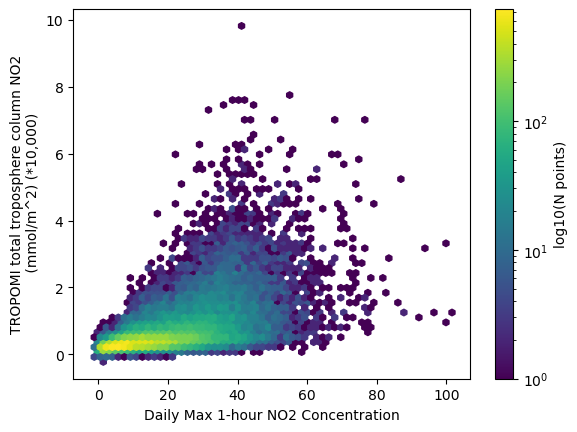

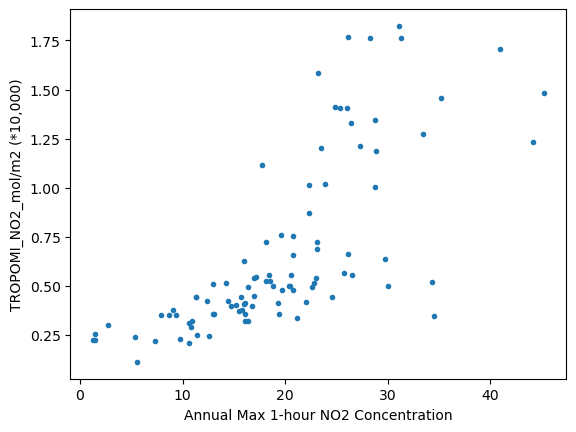

The daily pearson correlation is PearsonRResult(statistic=np.float64(0.5844103231786476), pvalue=np.float64(0.0))
The annual pearson correlation is PearsonRResult(statistic=np.float64(0.7218096232097638), pvalue=np.float64(1.5460264402051954e-16))


In [109]:
# TEST 1, Daily satellite NO2 mass data and ground concentration correlation
hb = plt.hexbin(
    site_data_filled['Daily Max 1-hour NO2 Concentration'],
    site_data_filled['TROPOMI_NO2_mol/m2'] * 10000,
    gridsize=60,
    cmap='viridis',
    bins='log'   # makes color scale logarithmic
)
cb = plt.colorbar(hb)
cb.set_label('log10(N points)')
plt.xlabel('Daily Max 1-hour NO2 Concentration')
plt.ylabel('TROPOMI total troposphere column NO2\n (mmol/m^2) (*10,000)')
plt.show()

# TEST 2, Annual average satellite NO2 mass data and ground concentration correlation
df = site_data_filled.dropna() # narm = T
df = df.groupby('ID_new')[['Daily Max 1-hour NO2 Concentration','TROPOMI_NO2_mol/m2' ]].agg('mean')
site_data_filled_dropna = site_data_filled.dropna()

plt.plot(df['Daily Max 1-hour NO2 Concentration'], df['TROPOMI_NO2_mol/m2']*10000, '.')
plt.xlabel('Annual Max 1-hour NO2 Concentration')
plt.ylabel('TROPOMI_NO2_mol/m2 (*10,000)')
plt.show()

# print pearson R
print(f'The daily pearson correlation is '
      f'{stats.pearsonr(site_data_filled_dropna['Daily Max 1-hour NO2 Concentration'], site_data_filled_dropna['TROPOMI_NO2_mol/m2'])}')
print(f'The annual pearson correlation is {stats.pearsonr(df['Daily Max 1-hour NO2 Concentration'], df['TROPOMI_NO2_mol/m2'])}')



## 4. Estimating Ground NO2 Concentration Based on TROPOMI data - Polynomial

Some preprocessess

In [110]:
# get calibration set ready
site_data_filled_dropna = site_data_filled.dropna()

x = site_data_filled_dropna[['TROPOMI_NO2_mol/m2']].values
y = site_data_filled_dropna['Daily Max 1-hour NO2 Concentration'].values

# apply standard scaler on independent variable for clibration stability
scaler = StandardScaler()
x = scaler.fit_transform(x)

#### Model selection: loop through degrees of polynomial


    Degree      R2     RMSE     Bias
0  1.00000 0.34421 10.68683 -0.05480
1  2.00000 0.40343 10.19288  0.05964
2  3.00000 0.41902 10.05877  0.05648
3  4.00000 0.42353 10.01969  0.04637
4  5.00000 0.42534 10.00393  0.04643
5  6.00000 0.42565 10.00125  0.04747
6  7.00000 0.42561 10.00160  0.04744
7  8.00000 0.42592  9.99889  0.05308
8  9.00000 0.42713  9.98837  0.05037
9 10.00000 0.42859  9.97562  0.04440


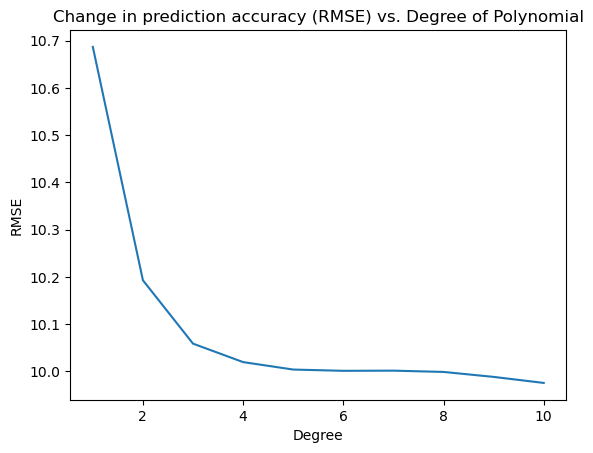

In [111]:
# set max degree of polynomial to loop through
Degree_max = 10

# call a df to storge validation result across degree increase
accuracy=pd.DataFrame(np.zeros([Degree_max,4]), columns=['Degree', 'R2', 'RMSE', 'Bias'])

# loop different degree of Polynomial
for i in range(1, Degree_max + 1):
    # crease Polynomial variable
    poly = PolynomialFeatures(degree=i, include_bias=False)
    x_poly = poly.fit_transform(x)

    # train test split
    x_train, x_test, y_train, y_test = train_test_split(
        x_poly, y, test_size=0.2, random_state=999
    )

    # fit
    model = LinearRegression(fit_intercept=True)
    model.fit(x_train, y_train)

    # predict on testing set
    y_pred = model.predict(x_test)

    # calculate metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    bias = np.mean(y_pred - y_test)

    # store metrics
    accuracy.loc[i-1, 'Degree'] = i
    accuracy.loc[i-1, 'R2'] = r2
    accuracy.loc[i-1, 'RMSE'] = rmse
    accuracy.loc[i-1, 'Bias'] = bias

print(accuracy)

plt.plot(accuracy['Degree'], accuracy['RMSE'], '-')
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.title('Change in prediction accuracy (RMSE) vs. Degree of Polynomial')
plt.show()

# accuracy.to_csv('Polynominal_accuracy.csv')


Polynomial degrees were progressively increased, and model performance was evaluated using the Root Mean Square Error (RMSE). A “stop-point” was defined: Based on the Elbow theory, we stop adding more degree to the model where RMSE improvements fell below 0.03 units with increasing degree. This threshold was defined based on the model performance variation across degrees in above graph.

### Final model trainning, and apply it for prediction

#### Calibration

Model: y = 23.125552378638318 + 14.918147688218845X + -5.9931845928613665X^2 + 1.2803665084247826X^3 + -0.12196563792431848X^4
Validation - Linear fit: y = 0.6025340407535573 + [0.9668702]X


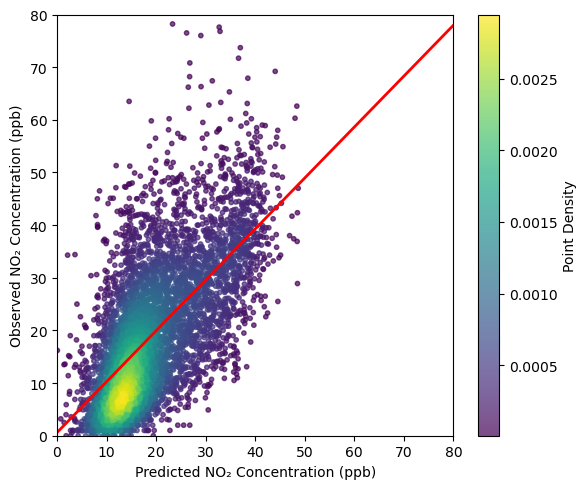

In [112]:
# Final model Degree = 5
poly = PolynomialFeatures(degree=5, include_bias=False)
x_poly = poly.fit_transform(x)

# split
x_train, x_test, y_train, y_test = train_test_split(
    x_poly, y, test_size=0.2, random_state=999
)

# fit
model = LinearRegression(fit_intercept=True)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(f'Model: y = {model.intercept_} + {model.coef_[0]}X'
      f' + {model.coef_[1]}X^2 + {model.coef_[2]}X^3 + {model.coef_[3]}X^4')

# final model validation linear fit line
model_val = LinearRegression(fit_intercept=True)
y_pred = y_pred.reshape(-1, 1)
model_val.fit(y_pred, y_test)
print(f'Validation - Linear fit: y = {model_val.intercept_} + {model_val.coef_}X')

# Stack points for density scatter
y_pred = y_pred.reshape(-1)
y_train = y_train.reshape(-1)
xy = np.vstack([y_pred, y_test])
z = gaussian_kde(xy)(xy)

plt.figure(figsize=(6,5))
sc = plt.scatter(y_pred, y_test, c=z, s=10, cmap='viridis', alpha=0.7)
cb = plt.colorbar(sc)
cb.set_label('Point Density')

# Fit line
plt.axline((0, 0.6), slope=0.967, color='red', linewidth=2)

plt.xlabel('Predicted NO₂ Concentration (ppb)')
plt.ylabel('Observed NO₂ Concentration (ppb)')
plt.xlim(0,80)
plt.ylim(0,80)
plt.tight_layout()
plt.show()



#### Prediction

In [113]:
# preparing prediction set
data_tif = rioxarray.open_rasterio(tif, masked=False)
TROPOMI_NO2 = data_tif.values.astype('float64').reshape(-1,1) # shape: (time, y, x)

# get non-nan data position
TROPOMI_NO2_isnotnan_mask = ~np.isnan(TROPOMI_NO2)

# scale and apply Polynomial on non-nan data for prediction
TROPOMI_NO2_scaled = scaler.transform(TROPOMI_NO2[TROPOMI_NO2_isnotnan_mask].reshape(-1,1))
TROPOMI_NO2_poly = poly.fit_transform(TROPOMI_NO2_scaled)

# prediction
NO2_pred = model.predict(TROPOMI_NO2_poly)

# fit prediction in to there previous position on modelling grid
TROPOMI_NO2[TROPOMI_NO2_isnotnan_mask] = NO2_pred

# Force negtive prediction to 0
TROPOMI_NO2[TROPOMI_NO2<0] = 0

# reshape to original dimension
data_tif.values = TROPOMI_NO2.reshape((366, 215, 235))


# data_tif.rio.to_raster("./Result/Predicted_Ground_NO2_Concentration_ppb.tif")
